# Dataset 1: Walmart Dataset Modelling (Traditional Models)

## Import Necessary Library

In [1]:
# System and warnings
import warnings
warnings.filterwarnings("ignore") # Suppress warnings for clean output

# Core libraries & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time series models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Automated SARIMA tuning
from pmdarima import auto_arima 

# Performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Read the Preprocessed Walmart Dataset

In [2]:
# Load the preprocessed Walmart Dataset
df = pd.read_csv('walmart_preprocessed.csv')

# Convert 'Date' column to datetime type for time series analysis
df['Date'] = pd.to_datetime(df['Date'])

# Display dataset and column data types
print("Dataset with all columns:")
display(df)
display(df.dtypes)

Dataset with all columns:


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day,Lag_52_Sales,Lag_1_Sales,Rolling_Mean_3W,Rolling_Std_3W,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,1,2,5,5,1.035127e+06,1.047210e+06,1.047133e+06,71789.192853,0,0,0,1
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,1,2,6,12,1.035127e+06,1.643691e+06,1.047133e+06,71789.192853,0,0,0,1
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,1,2,7,19,1.035127e+06,1.641957e+06,1.047133e+06,71789.192853,0,0,0,1
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,1,2,8,26,1.035127e+06,1.611968e+06,1.632539e+06,17835.791719,0,0,0,1
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,1,3,9,5,1.035127e+06,1.409728e+06,1.554551e+06,126313.968444,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,2012,3,9,39,28,6.989863e+05,7.230862e+05,7.306124e+05,32791.489809,1,0,0,0
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,2012,4,10,40,5,7.534471e+05,7.131739e+05,7.128328e+05,10428.150862,1,0,0,0
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,2012,4,10,41,12,7.209470e+05,7.334551e+05,7.232384e+05,10141.416679,1,0,0,0
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,2012,4,10,42,19,7.716864e+05,7.344644e+05,7.270311e+05,12011.272849,1,0,0,0


Store                       int64
Date               datetime64[ns]
Weekly_Sales              float64
Holiday_Flag                int64
Temperature               float64
Fuel_Price                float64
CPI                       float64
Unemployment              float64
Year                        int64
Quarter                     int64
Month                       int64
Week                        int64
Day                         int64
Lag_52_Sales              float64
Lag_1_Sales               float64
Rolling_Mean_3W           float64
Rolling_Std_3W            float64
Season_Autumn               int64
Season_Spring               int64
Season_Summer               int64
Season_Winter               int64
dtype: object

## Aggregate Weekly Sales Across All Stores

In [3]:
# Aggregate Weekly Sales Across All Stores (Focus for traditional models)
df_weekly = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
df_weekly.set_index('Date', inplace=True)

# Ensure Date index has weekly frequency (W-FRI for weekly Friday)
df_weekly.index = pd.DatetimeIndex(df_weekly.index, freq='W-FRI')

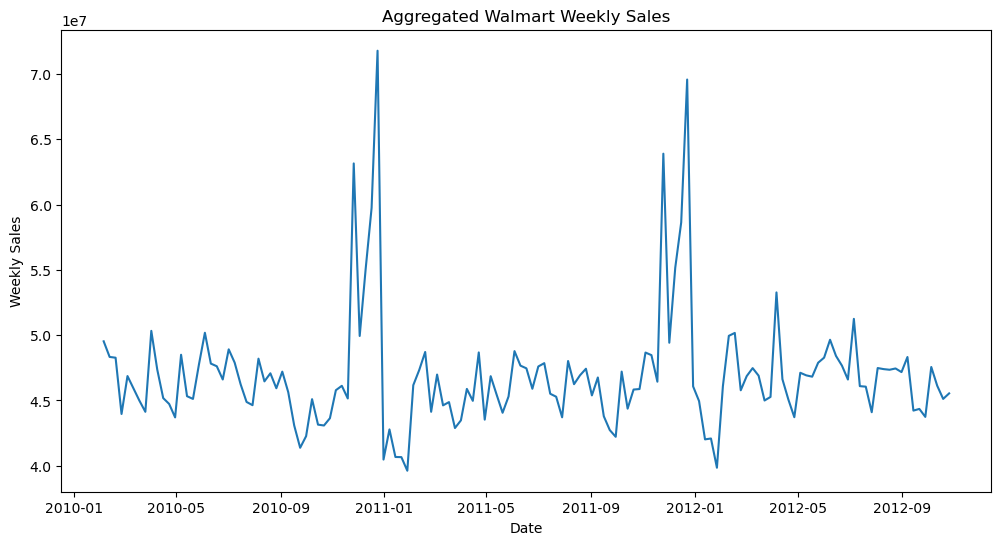

In [4]:
# Plot aggregated weekly sales
plt.figure(figsize=(12,6))
plt.plot(df_weekly.index, df_weekly['Weekly_Sales'], label='Weekly Sales')
plt.title('Aggregated Walmart Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

## Train-Test Split

In [5]:
# Use data before 2012 as training set and 2012 data as testing set
train = df_weekly[df_weekly.index.year < 2012]
test = df_weekly[df_weekly.index.year == 2012]

print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (100, 1), Test shape: (43, 1)


In [6]:
# Display train set
train

,Weekly_Sales
Date,
2010-02-05,49532665.77
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2011-12-02,49423546.24
2011-12-09,55170373.53
2011-12-16,58641375.94


In [7]:
# Display test set
test

,Weekly_Sales
Date,
2012-01-06,44955421.95
2012-01-13,42023078.48
2012-01-20,42089147.46
2012-01-27,39851104.28
2012-02-03,46085608.09
2012-02-10,49951824.86
2012-02-17,50174812.01
2012-02-24,45782029.97
2012-03-02,46866033.54


## Traditional Forecasting Modelling

### ARIMA Model

In [8]:
# ARIMA(p,d,q) model
# Using (0,0,0) for the simplest non-seasonal model (White Noise) to generate a forecast that acts as a baseline.
model_arima = ARIMA(train['Weekly_Sales'], order=(0,0,0))
model_arima_fit = model_arima.fit()

# Forecast using ARIMA
forecast_arima = model_arima_fit.forecast(steps=len(test))

### SARIMA Model

In [9]:
# Auto-ARIMA Search for optimal parameters
# m=52 is CRITICAL for capturing annual weekly seasonality
# trace=True shows the search process
# We set D=1 (seasonal differencing) and d=1 (regular differencing) as is common for retail data
stepwise_fit = auto_arima(train['Weekly_Sales'],
                          start_p=1, start_q=1,
                          max_p=3, max_q=3,
                          m=52, 
                          start_P=0, seasonal=True,
                          d=1, D=1,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

optimal_order = stepwise_fit.order
optimal_seasonal_order = stepwise_fit.seasonal_order

print(f"Optimal SARIMA Order: {optimal_order}")
print(f"Optimal Seasonal Order: {optimal_seasonal_order}")

# SARIMA Model with Optimized Parameters
model_sarima = SARIMAX(train['Weekly_Sales'].astype(float),
                        order=optimal_order,
                        seasonal_order=optimal_seasonal_order, # Uses m=52
                        enforce_stationarity=False,
                        enforce_invertibility=False)
model_sarima_fit = model_sarima.fit(disp=False)

# Forecast using SARIMA
forecast_sarima = model_sarima_fit.get_forecast(steps=len(test)).predicted_mean

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=1496.727, Time=3.74 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1525.578, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1495.549, Time=1.49 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1494.910, Time=1.80 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1507.177, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1496.897, Time=5.12 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=1496.897, Time=5.65 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1494.897, Time=1.52 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1496.897, Time=4.13 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=1498.897, Time=7.58 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=1498.404, Time=0.94 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1496.715, Time=4.65 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=1495.628, Time=2.15 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=1497.502, Time=6.38 sec
 ARIMA(0,1,1)(1,1,0

## Performance Evaluation

In [10]:
def evaluate_forecast(y_true, y_pred, model_name='Model'):
    """
    Evaluate forecasting performance using multiple metrics:
    MSE, RMSE, MAE, R² Score
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"--- {model_name} ---")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.4f}\n")

# Return metrics for the summary table
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R² Score': r2,
    }

# Collect results in a dictionary
results = {}
results['ARIMA'] = evaluate_forecast(test['Weekly_Sales'], forecast_arima, 'ARIMA')
results['SARIMA'] = evaluate_forecast(test['Weekly_Sales'], forecast_sarima, 'SARIMA')

# Present results in a DataFrame
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index':'Model'})

print("\n--- Final Model Performance Summary (Test Set) ---")
display(results_df.sort_values('RMSE'))

--- ARIMA ---
MSE: 6200373845523.35
RMSE: 2490054.99
MAE: 1807656.16
R² Score: -0.0620

--- SARIMA ---
MSE: 3007123325392.76
RMSE: 1734105.92
MAE: 1227772.38
R² Score: 0.4849


--- Final Model Performance Summary (Test Set) ---


,Model,MSE,RMSE,MAE,R² Score
1,SARIMA,3.007123e+12,1.734106e+06,1.227772e+06,0.484946
0,ARIMA,6.200374e+12,2.490055e+06,1.807656e+06,-0.061988


## Visual Evaluation

### 1. Residual Plots: Visualize errors for each model

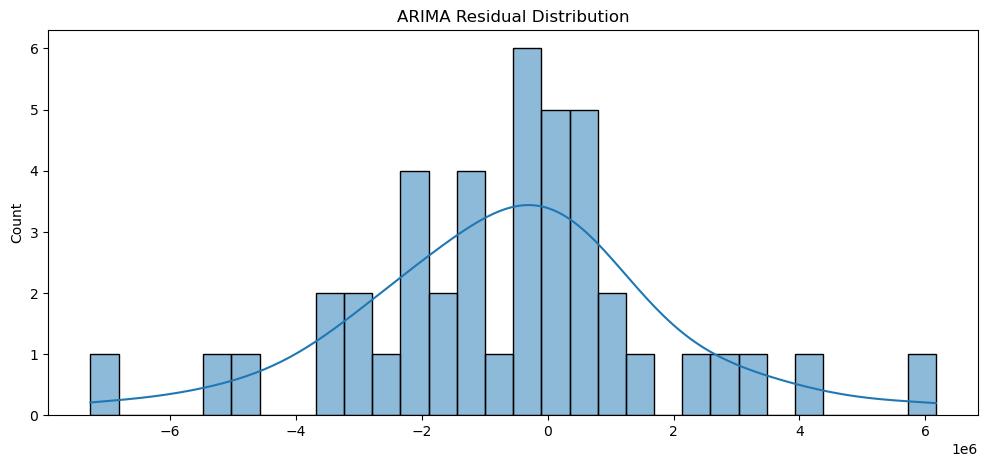

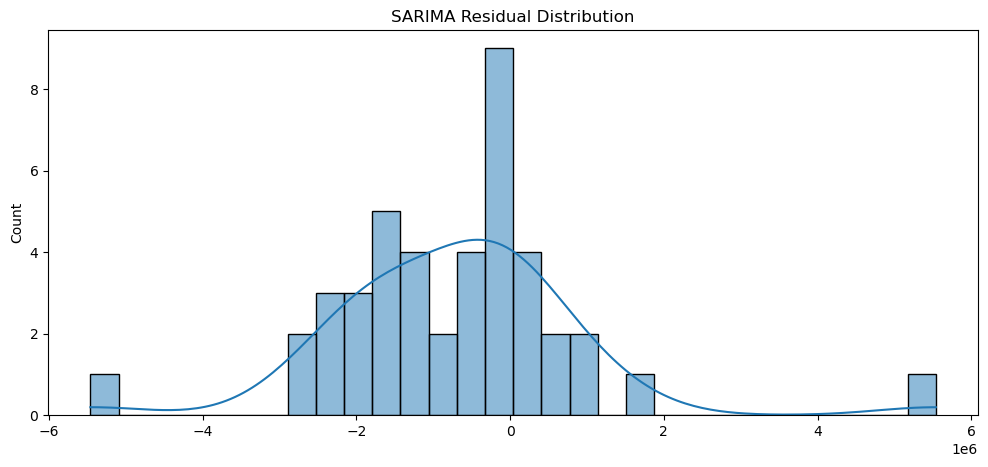

In [11]:
residuals_arima = test['Weekly_Sales'] - forecast_arima
residuals_sarima = test['Weekly_Sales'] - forecast_sarima

# ARIMA
plt.figure(figsize=(12,5))
sns.histplot(residuals_arima, kde=True, bins=30)
plt.title('ARIMA Residual Distribution')
plt.show()

# SARIMA
plt.figure(figsize=(12,5))
sns.histplot(residuals_sarima, kde=True, bins=30)
plt.title('SARIMA Residual Distribution')
plt.show()

### 2. Scatter Plots: Actual vs Predicted

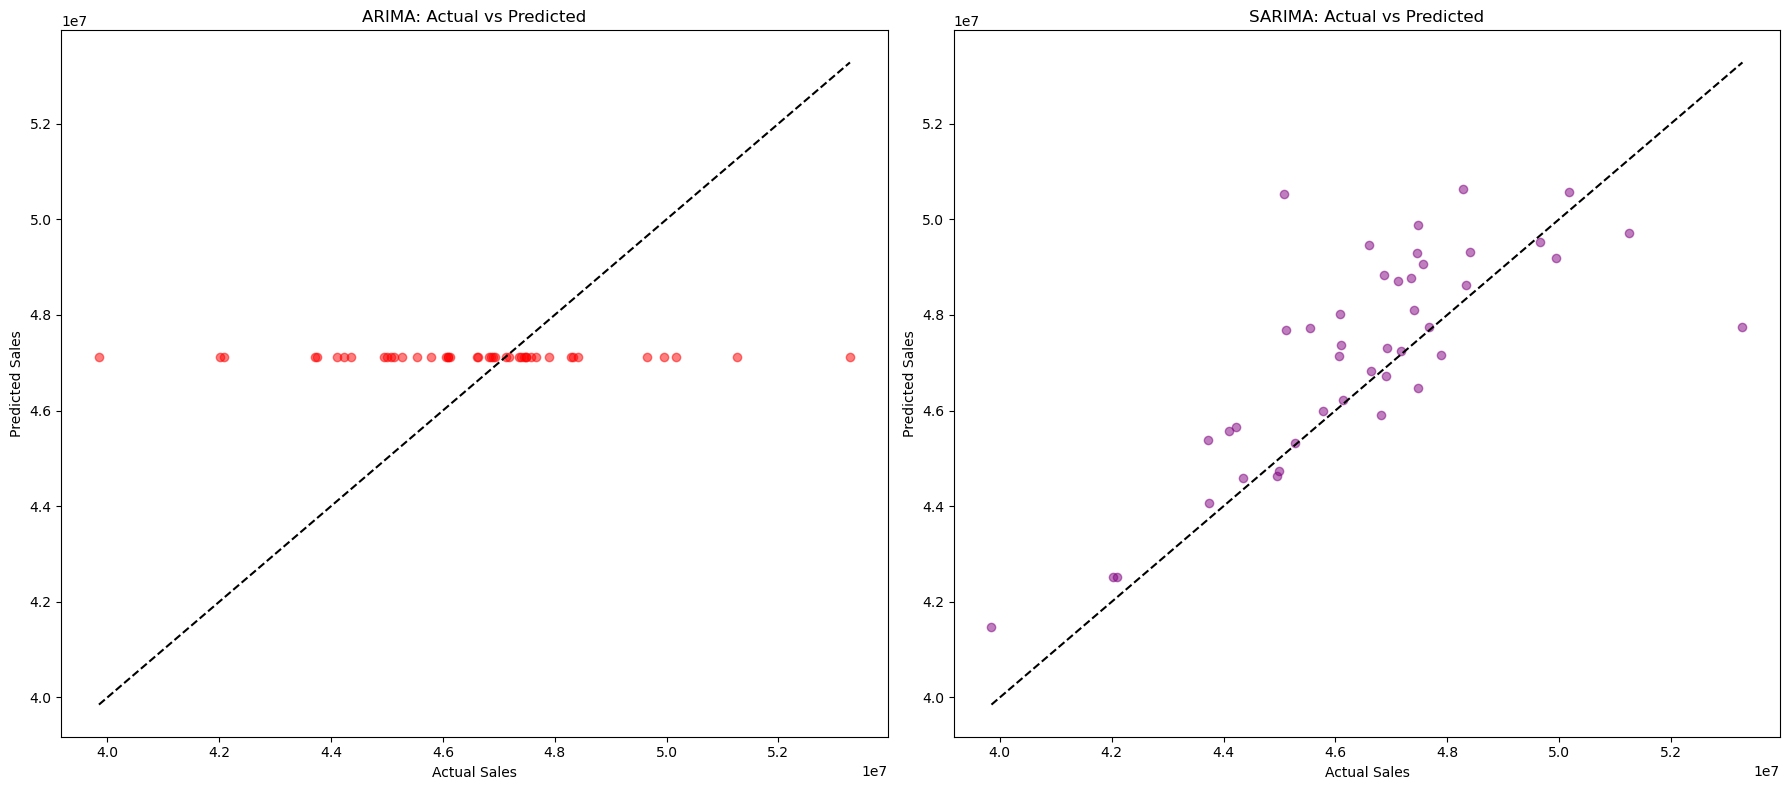

In [12]:
plt.figure(figsize=(18,8))

# ARIMA
plt.subplot(1,2,1)
plt.scatter(test['Weekly_Sales'], forecast_arima, alpha=0.5, color='red')
plt.plot([test['Weekly_Sales'].min(), test['Weekly_Sales'].max()],
         [test['Weekly_Sales'].min(), test['Weekly_Sales'].max()], color='black', linestyle='--')
plt.title('ARIMA: Actual vs Predicted')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')

# SARIMA
plt.subplot(1,2,2)
plt.scatter(test['Weekly_Sales'], forecast_sarima, alpha=0.5, color='purple')
plt.plot([test['Weekly_Sales'].min(), test['Weekly_Sales'].max()],
         [test['Weekly_Sales'].min(), test['Weekly_Sales'].max()], color='black', linestyle='--')
plt.title('SARIMA: Actual vs Predicted')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')

plt.tight_layout()
plt.show()

###  3. Line Plots: Time vs Forecast

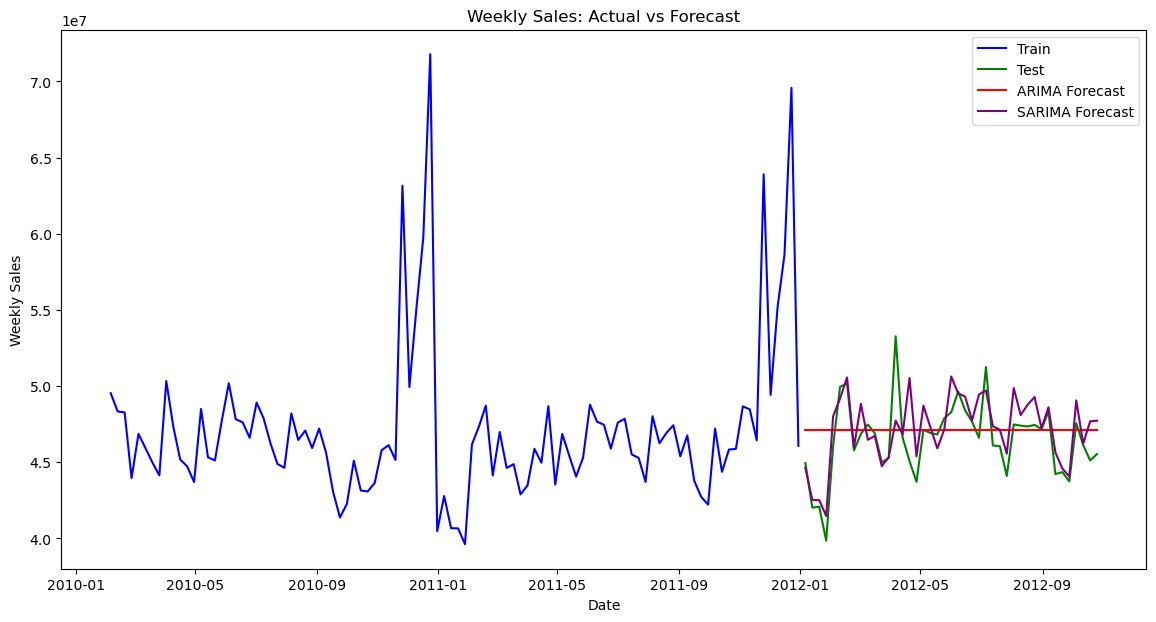

In [13]:
plt.figure(figsize=(14,7))
plt.plot(train.index, train['Weekly_Sales'], label='Train', color='blue')
plt.plot(test.index, test['Weekly_Sales'], label='Test', color='green')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', color='red')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', color='purple')
plt.title('Weekly Sales: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()